# 1. Setup Experimental

Nesta seção realizamos a configuração inicial do ambiente experimental.

O objetivo é:

- Garantir **reprodutibilidade científica**
- Importar bibliotecas necessárias
- Definir o dispositivo de execução (CPU/GPU)
- Estruturar os caminhos do dataset

Seguindo as diretrizes do edital, fixamos a semente aleatória (seed = 42) para assegurar consistência nos resultados ao longo das execuções.

Essa etapa é essencial para garantir:
- Controle experimental
- Robustez metodológica
- Integridade científica


In [95]:
# Bibliotecas Fundamentais
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Métricas
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


## 1.1 Reprodutibilidade

Para garantir a consistência dos experimentos, fixamos a semente aleatória em todas as bibliotecas relevantes.

Isso evita variações causadas por:

- Inicialização aleatória dos pesos
- Embaralhamento de dados
- Operações internas do backend CUDA

Essa prática é essencial em experimentos científicos e será mantida ao longo de todo o projeto.


In [96]:
# Reprodutibilidade
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)


## 1.2 Configuração do Dispositivo

O treinamento será realizado utilizando GPU quando disponível,
de forma a acelerar o processo de otimização do modelo.

Caso GPU não esteja disponível, o código executará automaticamente em CPU.


In [97]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Executando em: {device}")


Executando em: cpu


## 1.2.1 Configuração de Caminhos

Detecta automaticamente o ambiente (Colab vs local) e configura os paths.
Ajuste `CUSTOM_PROJECT_DIR` se necessário.

In [98]:
# Configuração de Caminhos
import sys
from pathlib import Path

# ============ Detecta ambiente ============
IN_COLAB = "google.colab" in sys.modules

# ============ Configuração de diretórios ============
CUSTOM_PROJECT_DIR = None  # Altere se necessário (ex: "/content/drive/MyDrive/Ligia_CV")

if CUSTOM_PROJECT_DIR:
    PROJECT_DIR = CUSTOM_PROJECT_DIR
elif IN_COLAB:
    # No Colab, monta o Drive e define o path padrão
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_DIR = "/content/drive/MyDrive/Ligia_CV"
else:
    # Local: assume que o notebook está em PROJECT_DIR/notebooks/
    cwd = Path.cwd()
    if cwd.name == "notebooks":
        PROJECT_DIR = str(cwd.parent)
    else:
        PROJECT_DIR = str(cwd)

# Data dir (dataset Kaggle)
DATA_DIR = os.path.join(PROJECT_DIR, "ligia-compviz")

print(f"PROJECT_DIR: {PROJECT_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"Colab: {IN_COLAB}")

PROJECT_DIR: /home/jose/Documentos/Ligia_CV
DATA_DIR: /home/jose/Documentos/Ligia_CV/ligia-compviz
Colab: False


## 1.3 Estrutura do Dataset

O dataset está organizado da seguinte forma:

- `test_images/test_images/` → imagens do conjunto de teste (sem rótulos)
- `train/train/NORMAL/` → imagens normais
- `train/train/PNEUMONIA/` → imagens com pneumonia
- `train/train.csv` → arquivo auxiliar
- `train/test.csv` → template de submissão

As imagens de treino estão separadas por classe em pastas distintas,
permitindo a construção manual de um DataFrame estruturado.


In [99]:
# Paths do Dataset

TEST_IMG_DIR  = os.path.join(DATA_DIR, "test_images/test_images")
TRAIN_ROOT    = os.path.join(DATA_DIR, "train")
TRAIN_IMG_DIR = os.path.join(TRAIN_ROOT, "train")

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

print("Test images:", TEST_IMG_DIR)
print("Train images:", TRAIN_IMG_DIR)


Test images: /home/jose/Documentos/Ligia_CV/ligia-compviz/test_images/test_images
Train images: /home/jose/Documentos/Ligia_CV/ligia-compviz/train/train


## 1.4 Verificação dos Caminhos (Sanity Check)

Antes de iniciar qualquer análise ou treinamento, validamos se os diretórios esperados realmente existem e se contêm arquivos.

Essa etapa evita erros comuns, como:
- caminho incorreto no `/kaggle/input/`
- pastas vazias por configuração errada do dataset
- divergências na estrutura de diretórios


In [100]:
print("TEST_IMG_DIR existe?", os.path.exists(TEST_IMG_DIR))
print("TRAIN_IMG_DIR existe?", os.path.exists(TRAIN_IMG_DIR))

print("\nAmostra de arquivos em test_images:", os.listdir(TEST_IMG_DIR)[:5])
print("Subpastas dentro de train/train:", os.listdir(TRAIN_IMG_DIR))

# contagem rápida
print("\nQtd test_images:", len(os.listdir(TEST_IMG_DIR)))
print("Qtd pneumonia:", len(os.listdir(os.path.join(TRAIN_IMG_DIR, "PNEUMONIA"))))
print("Qtd normal:", len(os.listdir(os.path.join(TRAIN_IMG_DIR, "NORMAL"))))


TEST_IMG_DIR existe? True
TRAIN_IMG_DIR existe? True

Amostra de arquivos em test_images: ['img_0255.jpeg', 'img_0580.jpeg', 'img_0453.jpeg', 'img_0421.jpeg', 'img_0223.jpeg']
Subpastas dentro de train/train: ['NORMAL', 'PNEUMONIA']

Qtd test_images: 624
Qtd pneumonia: 3883
Qtd normal: 1349


# 2. Entendimento do Problema

A presente competição consiste na classificação de imagens médicas
(Raio-X torácico) quanto à presença ou ausência de pneumonia.

Trata-se de um problema de:

- Classificação binária
- Domínio médico
- Potencial impacto clínico relevante

As classes são:

- 0 → Normal
- 1 → Pneumonia

---

## 2.1 Métrica de Avaliação

A métrica oficial é a **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**.

Isso implica que:

- O modelo deve retornar **probabilidades** da classe positiva (pneumonia).
- Não devemos enviar rótulos binários (0 ou 1).
- A qualidade do ranking das probabilidades é mais importante do que um threshold fixo.

A ROC-AUC mede a capacidade do modelo de:

> Discriminar corretamente entre imagens normais e imagens com pneumonia ao longo de diferentes limiares de decisão.

---

## 2.2 Implicações Clínicas

No contexto médico:

- Falso Negativo → paciente com pneumonia classificado como normal (erro grave).
- Falso Positivo → paciente saudável classificado como doente (impacto menor, mas relevante).

Portanto, além da ROC-AUC, analisaremos:

- Recall
- Matriz de Confusão
- Distribuição de erros

Essas análises serão discutidas posteriormente na seção de avaliação e interpretabilidade.


# 3. Análise Exploratória dos Dados (EDA Visual)

Antes de iniciar o treinamento do modelo, realizamos uma análise exploratória
visual das imagens disponíveis.

O objetivo desta etapa é:

- Verificar o balanceamento entre as classes
- Inspecionar padrões visuais característicos
- Identificar possíveis variações de resolução
- Observar diferenças estruturais entre casos normais e pneumonia

Essa etapa é fundamental para fundamentar decisões de:
- Pré-processamento
- Escolha de arquitetura
- Estratégias de data augmentation


## 3.1 Estrutura do Conjunto de Treino

O conjunto de treino está organizado em subpastas por classe, o que facilita a inspeção e a criação de um DataFrame para treinamento posteriormente.

- `PNEUMONIA/` → classe positiva (1)
- `NORMAL/` → classe negativa (0)

Nesta etapa, definimos os caminhos dessas pastas para facilitar a análise exploratória e garantir consistência ao longo do notebook.


In [101]:
PNE_DIR = os.path.join(TRAIN_IMG_DIR, "PNEUMONIA")
NOR_DIR = os.path.join(TRAIN_IMG_DIR, "NORMAL")

assert os.path.exists(PNE_DIR), "Pasta PNEUMONIA não encontrada."
assert os.path.exists(NOR_DIR), "Pasta NORMAL não encontrada."

print("PNE_DIR:", PNE_DIR)
print("NOR_DIR:", NOR_DIR)


PNE_DIR: /home/jose/Documentos/Ligia_CV/ligia-compviz/train/train/PNEUMONIA
NOR_DIR: /home/jose/Documentos/Ligia_CV/ligia-compviz/train/train/NORMAL


## 3.2 Distribuição das Classes

Nesta etapa, verificamos a quantidade de imagens disponíveis em cada classe.

Essa análise é importante porque:

- Desbalanceamento pode enviesar o treinamento (modelo “aprende” mais a classe majoritária).
- Métricas como ROC-AUC são mais adequadas do que acurácia em cenários desbalanceados.
- Pode ser necessário ajustar a função de perda (ex.: `pos_weight`) ou usar estratégias de validação estratificada.

A seguir, calculamos a contagem e a proporção de cada classe e exibimos um gráfico para facilitar a interpretação.


Pneumonia: 3883
Normal: 1349
Total: 5232
Proporção Pneumonia: 0.742
Proporção Normal: 0.258


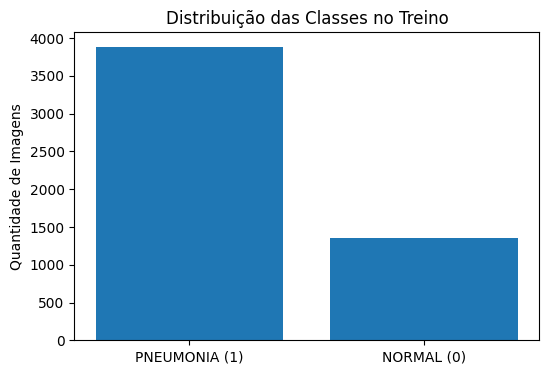

In [102]:

# Contagem de imagens por classe a partir das pastas
n_pne = len(os.listdir(PNE_DIR))    # classe positiva (pneumonia)
n_norm = len(os.listdir(NOR_DIR))  # classe negativa (normal)
total = n_pne + n_norm

# Exibição das quantidades brutas
print("Pneumonia:", n_pne)
print("Normal:", n_norm)
print("Total:", total)

# Cálculo das proporções (útil para entender desbalanceamento)
p_pne = n_pne / total
p_norm = n_norm / total

print(f"Proporção Pneumonia: {p_pne:.3f}")
print(f"Proporção Normal: {p_norm:.3f}")

# Plot simples para visualizar rapidamente o desbalanceamento
plt.figure(figsize=(6,4))
plt.bar(["PNEUMONIA (1)", "NORMAL (0)"], [n_pne, n_norm])
plt.title("Distribuição das Classes no Treino")
plt.ylabel("Quantidade de Imagens")
plt.show()


## 3.3 Visualização de Amostras

Nesta etapa, visualizamos algumas imagens aleatórias de cada classe para:

- Identificar padrões visuais iniciais (ex.: opacidades, regiões esbranquiçadas)
- Entender a variabilidade das imagens (contraste, posição, ruído)
- Verificar se existe alguma anomalia (ex.: imagens corrompidas, cortes estranhos)

Essa inspeção também orienta decisões futuras sobre pré-processamento e data augmentation.


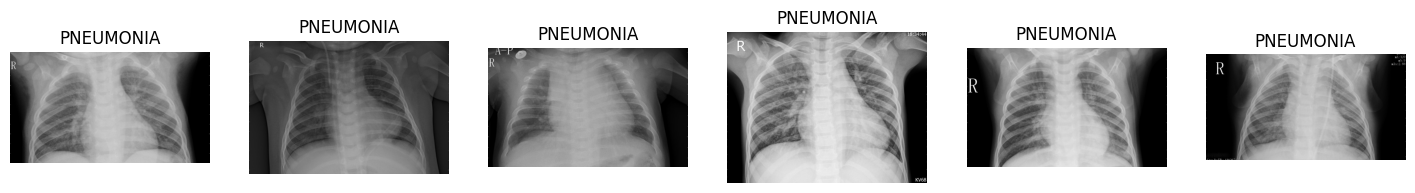

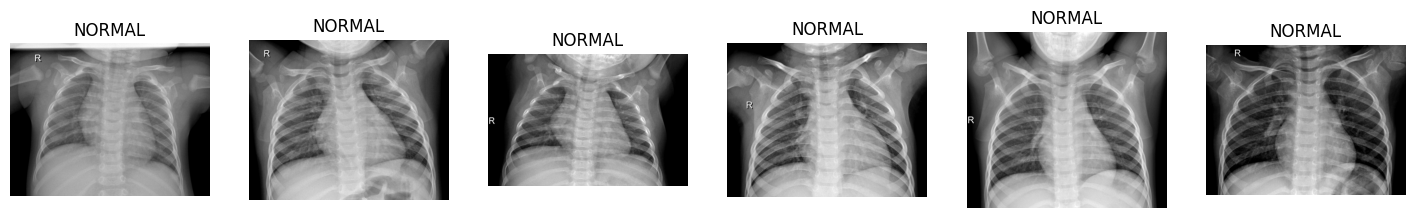

In [103]:
def show_random_images(folder, title, n=6, seed=SEED):

    #Mostra 'n' imagens aleatórias de uma pasta.
    #- folder: caminho da pasta
    #- title: título exibido no plot
    #- n: quantidade de imagens
    #- seed: para reprodutibilidade da amostra

    random.seed(seed)
    files = os.listdir(folder)
    samples = random.sample(files, k=min(n, len(files)))  # evita erro se n > total

    # Cria uma figura com n colunas
    plt.figure(figsize=(3*n, 3))
    for i, fname in enumerate(samples):
        path = os.path.join(folder, fname)

        # Abre a imagem (convertendo para RGB para evitar problemas de modo)
        img = Image.open(path).convert("RGB")

        # Plot
        plt.subplot(1, len(samples), i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.show()

# Mostra 6 imagens de pneumonia e 6 de normal
show_random_images(PNE_DIR, "PNEUMONIA", n=6)
show_random_images(NOR_DIR, "NORMAL", n=6)


### 3.3 Observações Iniciais (Inspeção Visual)

A inspeção visual de amostras aleatórias sugere diferenças consistentes entre as classes:

- **PNEUMONIA:** as imagens tendem a apresentar regiões mais **esbranquiçadas/opacas** no campo pulmonar, compatíveis com padrões de consolidação/infiltração.
- **NORMAL:** em geral observa-se maior presença de áreas **mais escuras** (maior “preto” associado ao ar nos pulmões), com melhor definição de estruturas internas.

Entretanto, foi possível observar que **algumas imagens normais podem aparecer levemente mais esbranquiçadas**, o que pode ocorrer por fatores de aquisição do exame (ex.: incidência/posição do raio-X, contraste, exposição). Esse comportamento é relevante pois pode gerar **falsos positivos**, que no contexto clínico tendem a ser menos graves do que falsos negativos (caso doente classificado como normal).

Além disso, a descrição do dataset indica que as imagens foram obtidas de **coortes retrospectivas de pacientes pediátricos (1 a 5 anos) do Guangzhou Women and Children’s Medical Center**. Isso é importante porque padrões anatômicos e a distribuição de contraste (proporção “preto/branco”) podem diferir significativamente de exames de adultos, afetando a generalização do modelo para outras populações. :contentReference[oaicite:1]{index=1}

Por fim, também notamos que em imagens normais costuma haver:
- **melhor visualização do contorno cardíaco**;
- **ossos mais brancos e nítidos**, o que pode servir como pista visual adicional para o modelo (mas também exige cuidado para evitar que o modelo aprenda “atalhos” incorretos).


## 3.4 Resolução e Proporção (Aspect Ratio)

Nesta etapa analisamos a resolução (largura x altura) e a proporção (W/H) das imagens do treino.

Motivações:

- Definir um tamanho padrão de entrada (`IMG_SIZE`) para modelos pré-treinados.
- Identificar variações de resolução que podem afetar o pré-processamento.
- Avaliar se o `Resize` para um tamanho fixo pode introduzir distorções relevantes.

Para tornar a análise rápida, usamos uma **amostra** de imagens ao invés de carregar todo o conjunto.


In [104]:
# Configurações da amostragem
sample_size = 300
random.seed(SEED)

# Lista de caminhos das imagens (misturando as duas classes)
pne_files = [os.path.join(PNE_DIR, f) for f in os.listdir(PNE_DIR)]
nor_files = [os.path.join(NOR_DIR, f) for f in os.listdir(NOR_DIR)]
all_train_files = pne_files + nor_files

# Amostra aleatória para acelerar (sem precisar abrir todas as imagens)
sample_paths = random.sample(all_train_files, k=min(sample_size, len(all_train_files)))

# Coleta de dimensões
widths, heights, ratios = [], [], []

for path in sample_paths:
    # Abre imagem somente para ler tamanho (leve)
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)
    ratios.append(w / h)

widths = np.array(widths)
heights = np.array(heights)
ratios = np.array(ratios)

# Estatísticas descritivas
print("Amostra analisada:", len(sample_paths))
print(f"Largura  - min/mediana/máx: {widths.min()} / {int(np.median(widths))} / {widths.max()}")
print(f"Altura   - min/mediana/máx: {heights.min()} / {int(np.median(heights))} / {heights.max()}")
print(f"Aspect   - min/mediana/máx: {ratios.min():.3f} / {np.median(ratios):.3f} / {ratios.max():.3f}")


Amostra analisada: 300
Largura  - min/mediana/máx: 448 / 1258 / 2480
Altura   - min/mediana/máx: 173 / 874 / 2096
Aspect   - min/mediana/máx: 0.958 / 1.407 / 2.590


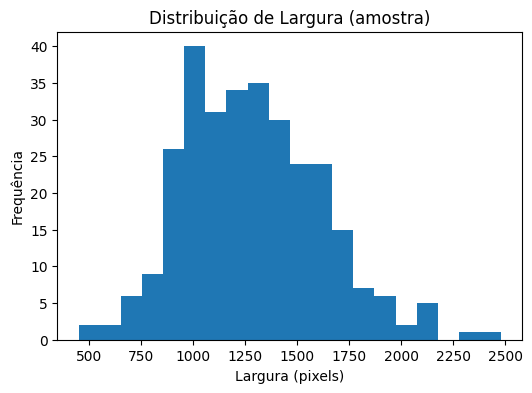

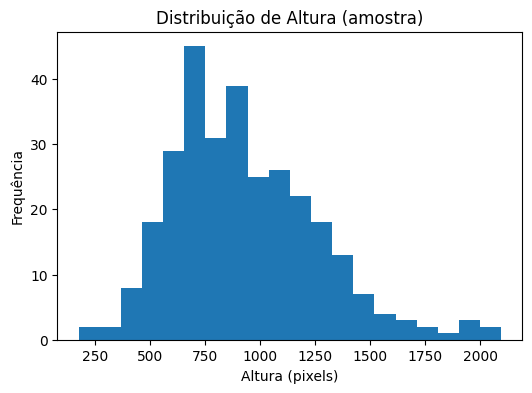

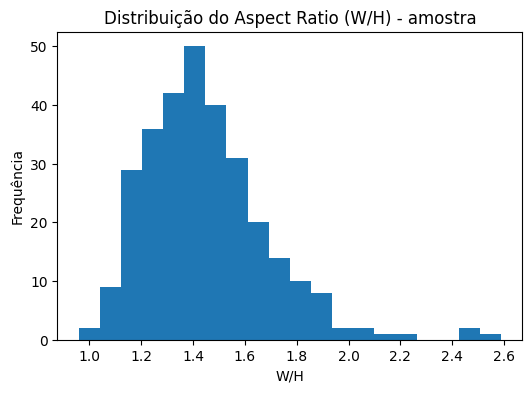

In [105]:
# Histograma de larguras
plt.figure(figsize=(6,4))
plt.hist(widths, bins=20)
plt.title("Distribuição de Largura (amostra)")
plt.xlabel("Largura (pixels)")
plt.ylabel("Frequência")
plt.show()

# Histograma de alturas
plt.figure(figsize=(6,4))
plt.hist(heights, bins=20)
plt.title("Distribuição de Altura (amostra)")
plt.xlabel("Altura (pixels)")
plt.ylabel("Frequência")
plt.show()

# Histograma do aspect ratio (W/H)
plt.figure(figsize=(6,4))
plt.hist(ratios, bins=20)
plt.title("Distribuição do Aspect Ratio (W/H) - amostra")
plt.xlabel("W/H")
plt.ylabel("Frequência")
plt.show()


### Interpretação

Observamos variação relevante na resolução das imagens (largura e altura), o que exige padronização antes do treinamento.
A maioria das imagens apresenta aspect ratio entre ~1.25 e 1.75, com alguns outliers mais extremos (até ~2.7), indicando que muitas imagens são mais largas do que altas.

Para utilizar modelos pré-treinados, é necessário definir um tamanho de entrada fixo. Inicialmente, adotaremos `Resize` para um tamanho padrão (ex.: 224×224) como baseline por simplicidade e reprodutibilidade. Em etapas posteriores, poderemos avaliar estratégias que preservem melhor a proporção geométrica, como padding (letterbox), caso a distorção afete a performance.


# 4. Construção do Dataset e Estratégia de Validação

Nesta seção construímos os DataFrames de treino e teste de forma consistente com os arquivos oficiais da competição:

- `train.csv` contém a referência oficial (`id`, `label`) para treinamento.
- `test.csv` contém os `id`s esperados no arquivo de submissão.

Além disso:
- validamos se os arquivos existentes nas pastas correspondem aos `id`s dos CSVs;
- montamos o caminho completo de cada imagem (`path`);
- definimos uma estratégia de validação com **StratifiedKFold**, preservando o desbalanceamento de classes em cada fold.


## 4.1 Carregamento dos CSVs Oficiais

Os CSVs fornecidos pela competição são a fonte oficial de:

- `id`: identificador do arquivo (inclui extensão `.jpeg`)
- `label`: rótulo binário no conjunto de treino

Nesta etapa, carregamos os CSVs e inspecionamos seu formato.


In [106]:
# 4.1 Leitura dos CSVs
# Usando funções do módulo src.data para carregar os DataFrames

import sys
sys.path.insert(0, PROJECT_DIR)

from src.data import sanity_check, load_train_df, load_test_df, add_folds

# Sanity check da estrutura do dataset
sanity_check(DATA_DIR)

# Carrega os CSVs oficiais como DataFrames
df_train = load_train_df(DATA_DIR, seed=SEED)
df_test = load_test_df(DATA_DIR)

display(df_train.head())
display(df_test.head())

print("Colunas df_train:", df_train.columns.tolist())
print("Colunas df_test:", df_test.columns.tolist())
print("Shapes:", df_train.shape, df_test.shape)


✅ Estrutura mínima OK.
📊 Contagens: NORMAL=1349 | PNEUMONIA=3883 | TEST=624


,id,label,path
0,NORMAL-9543520-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
1,NORMAL-8714707-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
2,VIRUS-2750119-0003.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
3,BACTERIA-1157929-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
4,BACTERIA-6171093-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...


,id,path
0,img_0001.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
1,img_0002.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
2,img_0003.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
3,img_0004.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
4,img_0005.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...


Colunas df_train: ['id', 'label', 'path']
Colunas df_test: ['id', 'path']
Shapes: (5232, 3) (624, 2)


## 4.2 Construção do DataFrame de Treino (`df_train`)

Construímos `df_train` a partir do `train.csv`, garantindo que:

- cada `id` tenha um arquivo correspondente na pasta de imagens;
- o `label` utilizado é o rótulo oficial fornecido pela competição.

Também criamos a coluna `path` com o caminho completo da imagem para uso no DataLoader.


In [ ]:
# Os dados já foram carregados na célula anterior usando load_train_df()
# Essa função já faz:
# - Leitura do train.csv
# - Checagem: todo id do train.csv precisa existir nas pastas
# - Criação do path correto de cada id (decide se está em PNE_DIR ou NOR_DIR)
# - Embaralhamento para não ficar com blocos ordenados

print("df_train shape:", df_train.shape)
print("Arquivos do train.csv que NÃO estão nas pastas: 0 (validado em load_train_df)")
df_train.head()


df_train shape: (5232, 3)
Arquivos do train.csv que NÃO estão nas pastas: 0 (validado em load_train_df)


,id,label,path
0,NORMAL-9543520-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
1,NORMAL-8714707-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
2,VIRUS-2750119-0003.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
3,BACTERIA-1157929-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
4,BACTERIA-6171093-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...


## 4.3 Construção do DataFrame de Teste (`df_test`)

No conjunto de teste, os rótulos não são fornecidos. O objetivo é:

- associar cada `id` do `test.csv` ao respectivo arquivo na pasta `test_images`;
- garantir que os `ids` utilizados na submissão sigam exatamente o formato esperado (incluindo `.jpeg`).


In [ ]:
# Os dados já foram carregados usando load_test_df()
# Essa função já faz:
# - Leitura do test.csv
# - Checagem: todo id do test.csv precisa existir na pasta test_images
# - Criação da coluna 'path' com caminho completo

print("df_test shape:", df_test.shape)
print("Arquivos do test.csv que NÃO estão na pasta: 0 (validado em load_test_df)")
df_test.head()


df_test shape: (624, 2)
Arquivos do test.csv que NÃO estão na pasta: 0 (validado em load_test_df)


,id,path
0,img_0001.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
1,img_0002.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
2,img_0003.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
3,img_0004.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...
4,img_0005.jpeg,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...


## 4.4 Validação com StratifiedKFold

Como o dataset é desbalanceado, utilizamos **StratifiedKFold** para que cada fold mantenha uma proporção de classes semelhante ao conjunto original.

Isso melhora a confiabilidade da validação e reduz variações artificiais entre folds.


In [109]:
# 4.4 Criação dos folds
# Usando add_folds() do módulo src.data

N_SPLITS = 5

df_train = add_folds(df_train, n_splits=N_SPLITS, seed=SEED)

# Checagem: distribuição de classes por fold (deve ser semelhante)
for f in range(N_SPLITS):
    counts = df_train[df_train["fold"] == f]["label"].value_counts(normalize=True)
    print(f"Fold {f} proporções:\n{counts}\n")

df_train.head()


Fold 0 proporções:
label
1    0.74212
0    0.25788
Name: proportion, dtype: float64

Fold 1 proporções:
label
1    0.74212
0    0.25788
Name: proportion, dtype: float64

Fold 2 proporções:
label
1    0.741874
0    0.258126
Name: proportion, dtype: float64

Fold 3 proporções:
label
1    0.741874
0    0.258126
Name: proportion, dtype: float64

Fold 4 proporções:
label
1    0.74283
0    0.25717
Name: proportion, dtype: float64



,id,label,path,fold
0,NORMAL-9543520-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...,1
1,NORMAL-8714707-0001.jpeg,0,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...,3
2,VIRUS-2750119-0003.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...,3
3,BACTERIA-1157929-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...,3
4,BACTERIA-6171093-0001.jpeg,1,/home/jose/Documentos/Ligia_CV/ligia-compviz/t...,3


# 5. Pré-processamento e DataLoaders

Nesta seção definimos como as imagens serão preparadas antes de entrarem no modelo.

Inclui:

- Definição do tamanho padrão da imagem (`IMG_SIZE`)
- Transformações para treino (com data augmentation controlado)
- Transformações para validação/teste (sem augmentation)
- Criação de um `Dataset` customizado e `DataLoader`

Como utilizaremos modelos pré-treinados, aplicamos normalização compatível com ImageNet.
Além disso, aplicamos augmentation apenas no treino para melhorar generalização,
mantendo validação/teste determinísticos.


## 5.1 Transformações (Transforms)

Como vimos no EDA, as imagens possuem resoluções e aspect ratios variados.
Para alimentar redes neurais, padronizamos o tamanho.

- **Treino:** inclui augmentations leves (ex.: rotação pequena e flip horizontal),
  visando robustez a variações de aquisição.
- **Validação/Teste:** apenas resize + normalização, para medir desempenho de forma estável.


In [ ]:
# Usando funções do módulo src.transforms

from src.transforms import get_train_tfms, get_valid_tfms

IMG_SIZE = 224  # baseline comum em modelos pré-treinados (ResNet/EfficientNet)

# Transformações do treino (com augmentation leve)
# - Resize: padroniza o tamanho
# - RandomHorizontalFlip: variação leve (não altera anatomia verticalmente)
# - RandomRotation: rotação pequena (simula variação de posicionamento)
# - ToTensor: converte para tensor [0,1]
# - Normalize: normalização ImageNet
train_tfms = get_train_tfms(IMG_SIZE)

# Transformações para validação e teste (sem augmentation)
valid_tfms = get_valid_tfms(IMG_SIZE)
print("train_tfms:", train_tfms)
print("valid_tfms:", valid_tfms)


train_tfms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
valid_tfms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 5.2 Dataset Customizado

Criamos um Dataset customizado para:

- Ler imagens a partir da coluna `path`
- Retornar `(imagem, label)` no treino/validação
- Retornar apenas `imagem` no teste

A conversão para `RGB` é utilizada para compatibilidade direta com modelos pré-treinados em ImageNet.


In [ ]:
# Usando XRayDataset do módulo src.data

from src.data import XRayDataset

# XRayDataset é uma classe Dataset customizada que:
# - Lê imagens a partir da coluna `path`
# - Retorna `(imagem, label)` no treino/validação
# - Retorna apenas `imagem` no teste
# - A conversão para `RGB` é utilizada para compatibilidade direta com modelos ImageNet

print("XRayDataset importado do src.data")
print("Uso: XRayDataset(df, transform=..., has_label=True/False)")


XRayDataset importado do src.data
Uso: XRayDataset(df, transform=..., has_label=True/False)


## 5.3 DataLoaders com Separação por Fold

Usaremos a coluna `fold` criada na Seção 4 para separar treino e validação.

Isso garante que:
- treino e validação são disjuntos
- a validação preserva a distribuição de classes (stratified)


In [112]:
# 5.3 DataLoaders com Separação por Fold
# Usando make_loaders() e make_test_loader() do módulo src.data

from src.data import make_loaders, make_test_loader

# make_loaders() usa a coluna `fold` para separar treino e validação
# Isso garante que:
# - treino e validação são disjuntos
# - a validação preserva a distribuição de classes (stratified)

# Exemplo: loaders do fold 0
train_loader, valid_loader = make_loaders(
    df_train,
    train_tfms=train_tfms,
    valid_tfms=valid_tfms,
    fold=0,
    batch_size=32
)

# Test loader
test_loader = make_test_loader(df_test, valid_tfms=valid_tfms, batch_size=32)

print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))
print("Test batches :", len(test_loader))


Train batches: 131
Valid batches: 33
Test batches : 20


# 6. Modelagem e Treinamento

Nesta seção definimos e treinamos um modelo de Deep Learning para classificar
imagens de raio-X torácico em:

- 0 → Normal
- 1 → Pneumonia

Como estratégia principal, utilizamos **Transfer Learning** com uma rede pré-treinada em ImageNet.
Isso é útil pois o dataset não é gigantesco e o modelo pré-treinado já possui filtros visuais
úteis (bordas, texturas, padrões), acelerando a convergência.

A saída do modelo será um **score contínuo** (logit), que será convertido em probabilidade via sigmoide.
A métrica de validação será a **ROC-AUC**, compatível com a avaliação da competição.


## 6.1 Arquitetura do Modelo

Usaremos a EfficientNet-B0 pré-treinada. Substituímos a camada final para produzir 1 logit:

- logit → `sigmoid(logit)` = probabilidade de pneumonia

Essa configuração é adequada para classificação binária com `BCEWithLogitsLoss`,
que aplica internamente a sigmoide de forma numericamente estável.


In [113]:
# 6.1 Arquitetura do Modelo
# Usando build_model() do módulo src.model

from src.model import build_model

# build_model() constrói EfficientNet-B0 pré-treinada com camada final adaptada:
# - Carrega EfficientNet-B0 pré-treinada (ImageNet)
# - Troca a camada final para saída binária (1 logit)
# - logit → `sigmoid(logit)` = probabilidade de pneumonia
#
# Essa configuração é adequada para classificação binária com `BCEWithLogitsLoss`,
# que aplica internamente a sigmoide de forma numericamente estável.

print("build_model importado do src.model")
print("Uso: model = build_model(pretrained=True)")


build_model importado do src.model
Uso: model = build_model(pretrained=True)


## 6.2 Função de Perda e Otimizador

Como o dataset é desbalanceado (maioria pneumonia), utilizamos `pos_weight` na loss
para penalizar mais erros na classe positiva (pneumonia).

A loss escolhida é:

- `BCEWithLogitsLoss(pos_weight=...)`

Otimizador:
- `AdamW` (boa estabilidade e regularização via weight decay)

Scheduler:
- `CosineAnnealingLR` (reduz a taxa de aprendizado suavemente ao longo das épocas)


In [114]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def get_criterion(df):
    # Calcula pos_weight = (negativos / positivos)
    pos = (df["label"] == 1).sum()
    neg = (df["label"] == 0).sum()
    pos_weight = torch.tensor([neg / pos], device=device, dtype=torch.float32)

    print("pos_weight:", pos_weight.item())
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

criterion = get_criterion(df_train)


pos_weight: 0.34741178154945374


## 6.3 Treino e Validação

Durante o treino, o modelo recebe imagens e retorna logits.
Na validação, convertemos logits em probabilidades usando `sigmoid` e calculamos ROC-AUC.

Importante:
- ROC-AUC usa **scores contínuos** (probabilidades), não rótulos 0/1.


In [115]:
from sklearn.metrics import roc_auc_score
import numpy as np

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1)  # shape (B,1)

        optimizer.zero_grad()

        logits = model(x)             # saída: logit
        loss = criterion(logits, y)   # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    probs = []
    ys = []

    for x, y in loader:
        x = x.to(device)

        logits = model(x)
        p = torch.sigmoid(logits).cpu().numpy().ravel()  # probabilidade de pneumonia

        probs.append(p)
        ys.append(y.numpy().ravel())

    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    auc = roc_auc_score(ys, probs)
    return auc

## 6.4 Carregamento de Modelos Pré-treinados (Reprodução Rápida)

Para reprodução rápida sem necessidade de retreinamento, carregamos os checkpoints
salvos em `models/` e geramos as predições usando ensemble.

Esta célula:
- Carrega os 5 checkpoints (`best_model_fold{0-4}.pth`)
- Gera predições no conjunto de teste usando `ensemble_predict`
- Define `test_pred_mean` necessário para a submissão

In [116]:
# 6.6 Carregamento de Modelos e Ensemble (sem treinar)

from src.inference import ensemble_predict, predict_proba, load_checkpoint, save_submission

N_SPLITS = 5
BATCH_SIZE = 32
NUM_WORKERS = 2

# Diretório dos checkpoints
MODELS_DIR = os.path.join(PROJECT_DIR, "models")

# Lista de caminhos dos checkpoints
checkpoint_paths = [os.path.join(MODELS_DIR, f"best_model_fold{i}.pth") for i in range(N_SPLITS)]

# Verifica se todos os checkpoints existem
missing = [p for p in checkpoint_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"Checkpoints não encontrados: {missing}\n"
                            f"Execute o notebook train.ipynb primeiro ou rode a Seção 6.5.")

print(f"✅ Todos os {N_SPLITS} checkpoints encontrados em: {MODELS_DIR}")

# DataLoader de teste
test_loader = make_test_loader(
    df_test,
    valid_tfms=valid_tfms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

# Ensemble: carrega cada modelo e faz a média das probabilidades
print("🔄 Carregando modelos e gerando predições...")
test_pred_mean = ensemble_predict(build_model, checkpoint_paths, test_loader, device)

print(f"✅ test_pred_mean gerado com shape: {test_pred_mean.shape}")
print(f"   min={test_pred_mean.min():.4f}, max={test_pred_mean.max():.4f}, mean={test_pred_mean.mean():.4f}")

✅ Todos os 5 checkpoints encontrados em: /home/jose/Documentos/Ligia_CV/models
🔄 Carregando modelos e gerando predições...
✅ test_pred_mean gerado com shape: (624,)
   min=0.0000, max=0.9999, mean=0.7010


# 7. Avaliação e Análise de Erros (Fold 0)

A métrica principal da competição é ROC-AUC, que mede a capacidade do modelo de ranquear corretamente
exemplos positivos acima de negativos, sem exigir um limiar (threshold) fixo.

Entretanto, para interpretar o comportamento do modelo em um cenário de decisão binária
(e para o relatório), também avaliamos métricas dependentes de threshold:

- Matriz de confusão (TN, FP, FN, TP)
- Precision, Recall, F1-score
- Análise qualitativa de erros (FP e FN)

**Observação importante:** escolher um threshold é uma decisão de "métrica de negócio".
Em aplicações médicas, geralmente buscamos **alto recall** (reduzir falsos negativos),
mesmo que isso aumente falsos positivos.


## 7.1 Probabilidades na validação (Fold 0)

Nesta etapa:
1. Selecionamos o conjunto de validação do fold 0 (definido pelo StratifiedKFold).
2. Carregamos o checkpoint salvo (`best_model_fold0.pth`).
3. Geramos probabilidades para cada imagem do fold 0:

- O modelo retorna **logits** (valores reais).
- Aplicamos `sigmoid(logit)` para obter **probabilidade** de pneumonia.

Essas probabilidades serão usadas para ROC-AUC, matriz de confusão e análise de erros.


In [118]:
# 7.1 Gerar probabilidades na validação (Fold 0)
# Usando load_checkpoint e predict_proba do src.inference

FOLD_ANALYSIS = 0
BATCH_SIZE = 32
NUM_WORKERS = 2

# Diretório dos checkpoints (mesmo da Seção 6.6)
MODELS_DIR = os.path.join(PROJECT_DIR, "models")

# 1) Filtra os dados do fold 0 (validação)
df_va = df_train[df_train["fold"] == FOLD_ANALYSIS].reset_index(drop=True)

# 2) DataLoader da validação (sem shuffle para manter a ordem)
# Usando XRayDataset do src.data
val_dataset = XRayDataset(df_va, transform=valid_tfms, has_label=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

# 3) Carrega checkpoint salvo do melhor modelo (fold 0) usando load_checkpoint
checkpoint_path = os.path.join(MODELS_DIR, "best_model_fold0.pth")
model = build_model()
model = load_checkpoint(model, checkpoint_path, device)

# 4) Gera probabilidades p(y=1) usando predict_proba do src.inference
val_probs = predict_proba(model, val_loader, device)  # shape (N,)
val_true  = df_va["label"].values                     # shape (N,)

print("val_probs shape:", val_probs.shape)
print("ROC-AUC (fold 0):", roc_auc_score(val_true, val_probs))

val_probs shape: (1047,)
ROC-AUC (fold 0): 0.998913198913199


## 7.2 Métricas com threshold (0.5)

Como baseline, usamos threshold = 0.5:

- Se `p >= 0.5`, o modelo prediz pneumonia (classe 1).
- Caso contrário, prediz normal (classe 0).

A matriz de confusão segue o padrão:

[[TN, FP],
 [FN, TP]]

Onde:
- **FN** (falso negativo) é o caso mais crítico: pneumonia predita como normal.
- **FP** (falso positivo) pode gerar alarme indevido, mas é menos crítico em triagem.


In [119]:
# 7.2 Matriz de confusão + relatório (threshold=0.5)

from sklearn.metrics import confusion_matrix, classification_report

thr = 0.5

# Converte probabilidade em predição binária
val_pred = (val_probs >= thr).astype(int)

# Matriz de confusão
cm = confusion_matrix(val_true, val_pred)
print("Confusion Matrix [[TN, FP],[FN, TP]]:\n", cm)

# Relatório completo: precision/recall/f1 por classe
print("\nClassification Report:\n")
print(classification_report(val_true, val_pred, digits=4))


Confusion Matrix [[TN, FP],[FN, TP]]:
 [[267   3]
 [ 20 757]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9303    0.9889    0.9587       270
           1     0.9961    0.9743    0.9850       777

    accuracy                         0.9780      1047
   macro avg     0.9632    0.9816    0.9719      1047
weighted avg     0.9791    0.9780    0.9782      1047



## 7.3 Ajuste de threshold focando recall (métrica de negócio)

Como ROC-AUC é independente de threshold, a escolha de limiar é uma decisão do sistema.

Aqui testamos vários thresholds e escolhemos aquele que maximiza **recall** na validação.
Isso tende a reduzir FN (mais segurança), porém aumenta FP.


In [120]:
# 7.3 Buscar threshold que maximize recall

thresholds = np.linspace(0.05, 0.95, 19)

best_thr = 0.5
best_recall = -1
best_tuple = None  # (tn, fp, fn, tp)

for t in thresholds:
    pred = (val_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_true, pred).ravel()

    # Recall = TP / (TP + FN)
    recall = tp / (tp + fn + 1e-9)

    if recall > best_recall:
        best_recall = recall
        best_thr = t
        best_tuple = (tn, fp, fn, tp)

tn, fp, fn, tp = best_tuple
print("Melhor threshold (max recall):", best_thr)
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print("Recall nesse threshold:", best_recall)


Melhor threshold (max recall): 0.05
TN=259 FP=11 FN=7 TP=770
Recall nesse threshold: 0.9909909909897155


## 7.4 Inspeção visual de erros (FP e FN)

Para interpretar os erros, exibimos imagens classificadas incorretamente:

- **Falsos Positivos (FP):** normal predito como pneumonia
- **Falsos Negativos (FN):** pneumonia predito como normal (mais crítico)

Nos gráficos, mostramos `p=...` acima de cada imagem:

- `p` é a probabilidade prevista de pneumonia (`target`).
- Ex.: `p=0.62` significa que o modelo estimou 62% de chance de pneumonia.

A inspeção visual ajuda a entender:
- padrões de erro associados a contraste/exposição do raio X
- casos ambíguos e “difíceis”
- possíveis atalhos (spurious correlations) que o modelo pode estar usando


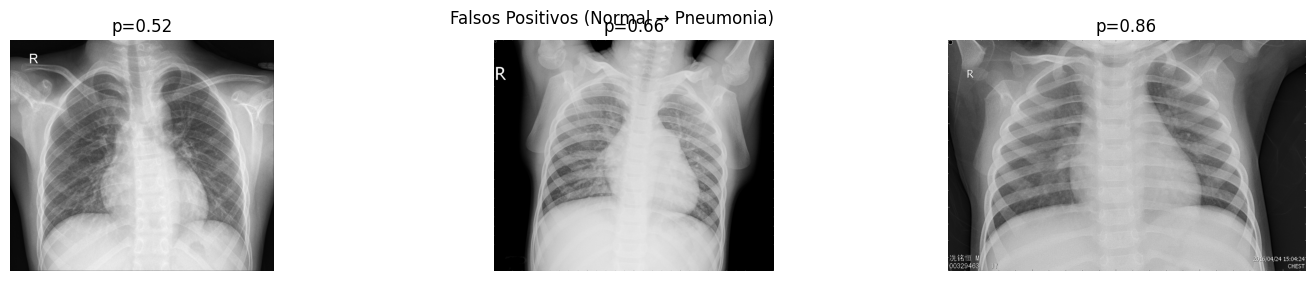

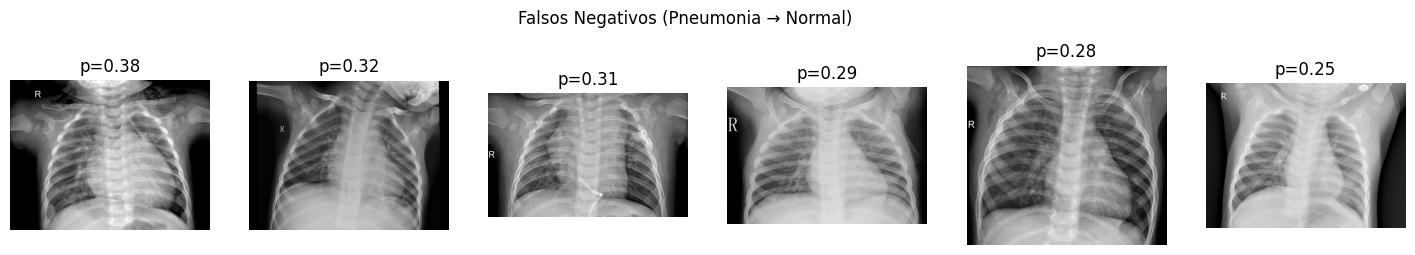

In [121]:
# 7.4 Mostrar exemplos de FP/FN para análise de erro

def show_examples(df_va, y_true, y_prob, kind="FN", thr=0.5, n=6):

    #Exibe exemplos de erros com a probabilidade prevista p(y=1) no título.

    #kind="FN": y=1 e pred=0
    #kind="FP": y=0 e pred=1

    y_pred = (y_prob >= thr).astype(int)

    if kind == "FN":
        idx = np.where((y_true == 1) & (y_pred == 0))[0]
        title = "Falsos Negativos (Pneumonia → Normal)"
    else:
        idx = np.where((y_true == 0) & (y_pred == 1))[0]
        title = "Falsos Positivos (Normal → Pneumonia)"

    if len(idx) == 0:
        print(f"Nenhum exemplo de {kind} encontrado nesse threshold.")
        return

    # Seleciona os exemplos mais próximos do threshold (casos mais ambíguos)
    idx = sorted(idx, key=lambda i: abs(y_prob[i] - thr))[:n]

    plt.figure(figsize=(3*n, 3))
    for j, k in enumerate(idx):
        path = df_va.loc[k, "path"]
        img = Image.open(path).convert("RGB")

        plt.subplot(1, len(idx), j+1)
        plt.imshow(img)
        plt.title(f"p={y_prob[k]:.2f}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

# Use thr=0.5 para a análise padrão
show_examples(df_va, val_true, val_probs, kind="FP", thr=0.5, n=6)
show_examples(df_va, val_true, val_probs, kind="FN", thr=0.5, n=6)


# 8. Interpretabilidade (XAI) com Grad-CAM

Para entender melhor como o modelo toma decisões, aplicamos Grad-CAM (Gradient-weighted Class Activation Mapping).

O Grad-CAM produz um mapa de calor que indica as regiões da imagem que mais contribuíram para a predição.
Isso é útil para:

- validar se o modelo está focando em regiões clinicamente plausíveis (ex.: áreas pulmonares);
- investigar erros (FP e FN) e possíveis "atalhos" (artefatos, bordas, textos, contraste);
- enriquecer o relatório com interpretabilidade, conectando métricas com explicações visuais.

Nesta seção:
- carregamos o melhor modelo do fold 0 (checkpoint salvo);
- selecionamos exemplos (TP, FP, FN) do fold 0;
- geramos mapas Grad-CAM e sobrepomos na imagem original.


## 8.1 Carregar modelo (Fold 0)

Usaremos o mesmo checkpoint utilizado na Seção 7 (`best_model_fold0.pth`) para garantir consistência:
as explicações (Grad-CAM) refletem exatamente o modelo avaliado.


In [122]:
# 8.1 Carrega o checkpoint do fold 0 usando load_checkpoint do src.inference
checkpoint_path = os.path.join(MODELS_DIR, "best_model_fold0.pth")
model = build_model()
model = load_checkpoint(model, checkpoint_path, device)

print("✅ Modelo do fold 0 carregado para Grad-CAM.")

✅ Modelo do fold 0 carregado para Grad-CAM.


## 8.2 Implementação do Grad-CAM

O Grad-CAM usa:
- as ativações de uma camada convolucional (feature maps)
- os gradientes da saída (classe positiva) em relação a essas ativações

Em seguida, calcula um mapa de calor 2D (H×W) que indica a contribuição de cada região.

Escolhemos como camada alvo a última camada convolucional da EfficientNet (último bloco em `model.features`),
pois ela costuma capturar padrões de alto nível relevantes para a decisão.


In [123]:
class GradCAM:

    # Implementação simples de Grad-CAM para um modelo PyTorch.
    # Funciona bem para arquiteturas conv (como EfficientNet/ResNet).

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # Hook: captura ativações no forward
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        # Hook: captura gradientes no backward
        def backward_hook(module, grad_in, grad_out):
            # grad_out é uma tupla; grad_out[0] é o gradiente das ativações
            self.gradients = grad_out[0].detach()

        self.fwd_handle = self.target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = self.target_layer.register_full_backward_hook(backward_hook)

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

    def __call__(self, x):

        # x: tensor (1, C, H, W) já transformado/normalizado.
        # Retorna:
        # - cam: heatmap 2D normalizado [0,1] (H, W)
        # - prob: probabilidade prevista p(y=1)

        self.model.zero_grad()

        # Forward: logits
        logits = self.model(x)                  # shape (1,1)
        prob = torch.sigmoid(logits).item()

        # Backward: gradiente do logit da classe positiva (pneumonia)
        logits.backward(torch.ones_like(logits))

        # Ativações e gradientes: (1, C, h, w)
        A = self.activations
        dA = self.gradients

        # Pesos = média global dos gradientes por canal: (C,)
        weights = dA.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Combinação ponderada dos mapas: (1, 1, h, w)
        cam = (weights * A).sum(dim=1, keepdim=True)

        # ReLU (mantém apenas contribuições positivas)
        cam = torch.relu(cam)

        # Normaliza para [0,1]
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-9)

        return cam, prob


## 8.3 Visualização

Para visualizar o Grad-CAM:
- carregamos a imagem original (para exibição)
- aplicamos as transformações de validação (`valid_tfms`) para alimentar o modelo
- geramos o mapa Grad-CAM em baixa resolução e fazemos resize para o tamanho da imagem exibida
- sobrepomos o heatmap na imagem original


In [124]:
import cv2

def load_image_rgb(path):
    # Carrega imagem como RGB (PIL).
    return Image.open(path).convert("RGB")

def tensor_from_path(path):
    # Aplica valid_tfms e retorna tensor (1,C,H,W).
    img = load_image_rgb(path)
    x = valid_tfms(img).unsqueeze(0).to(device)
    return x

def overlay_heatmap_on_image(img_pil, cam, alpha=0.4):

    # Sobrepõe o heatmap (cam) em uma imagem PIL.
    # cam: array 2D em [0,1]

    img = np.array(img_pil)  # (H,W,3) RGB
    H, W = img.shape[:2]

    # Redimensiona CAM para o tamanho da imagem
    cam_resized = cv2.resize(cam, (W, H))

    # Converte cam em heatmap colorido (colormap)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Combina imagem + heatmap
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    return overlay

def show_gradcam(path, cam, prob, title=""):
    # Exibe imagem original e imagem com overlay do Grad-CAM.
    img = load_image_rgb(path)
    overlay = overlay_heatmap_on_image(img, cam, alpha=0.4)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"{title}\n p(pneumonia)={prob:.3f}")
    plt.axis("off")
    plt.show()


## 8.4 Seleção de exemplos para análise (TP / FP / FN)

Usamos as probabilidades da validação (Seção 7) para selecionar exemplos representativos:
- **TP**: pneumonia correta com alta confiança
- **FP**: normal predito como pneumonia (erro)
- **FN**: pneumonia predito como normal (erro mais crítico)

Isso facilita escolher casos informativos sem seleção manual.


In [125]:
# 8.4 Seleciona índices de TP/FP/FN com threshold 0.5

thr = 0.5
val_pred = (val_probs >= thr).astype(int)

# índices por tipo
tp_idx = np.where((val_true == 1) & (val_pred == 1))[0]
fp_idx = np.where((val_true == 0) & (val_pred == 1))[0]
fn_idx = np.where((val_true == 1) & (val_pred == 0))[0]

print("TP:", len(tp_idx), "FP:", len(fp_idx), "FN:", len(fn_idx))

# Escolhas "informativas":
# - TP mais confiante: maior prob
tp_best = tp_idx[np.argmax(val_probs[tp_idx])] if len(tp_idx) else None

# - FP mais confiante: maior prob (modelo muito certo e mesmo assim errou)
fp_best = fp_idx[np.argmax(val_probs[fp_idx])] if len(fp_idx) else None

# - FN mais "perigoso": menor prob (modelo muito certo que é normal, mas era pneumonia)
fn_best = fn_idx[np.argmin(val_probs[fn_idx])] if len(fn_idx) else None

tp_best, fp_best, fn_best


TP: 757 FP: 3 FN: 20


(np.int64(974), np.int64(591), np.int64(454))

## 8.5 Grad-CAM nos exemplos selecionados

Geramos o Grad-CAM para cada caso e verificamos se as regiões destacadas fazem sentido.

Idealmente:
- casos de pneumonia: o modelo deve destacar regiões pulmonares com opacidades/infiltrados;
- casos normais: o foco não deveria estar em bordas, marcas ou regiões fora do tórax.

Em erros (FP/FN), analisamos se o modelo foi "enganado" por contraste, exposição ou artefatos.


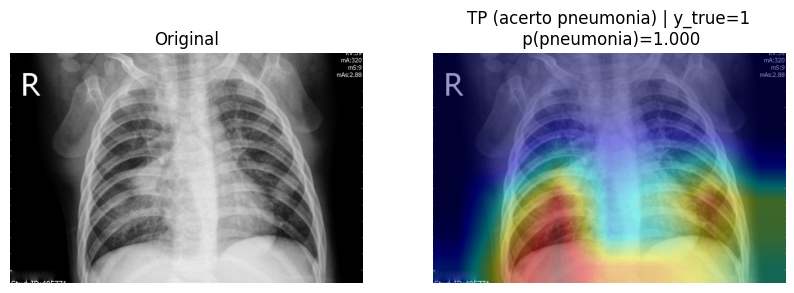

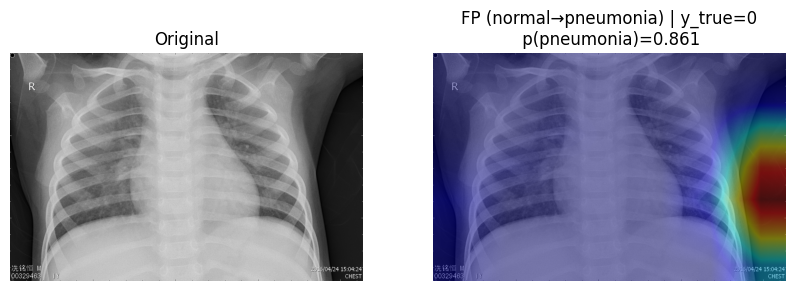

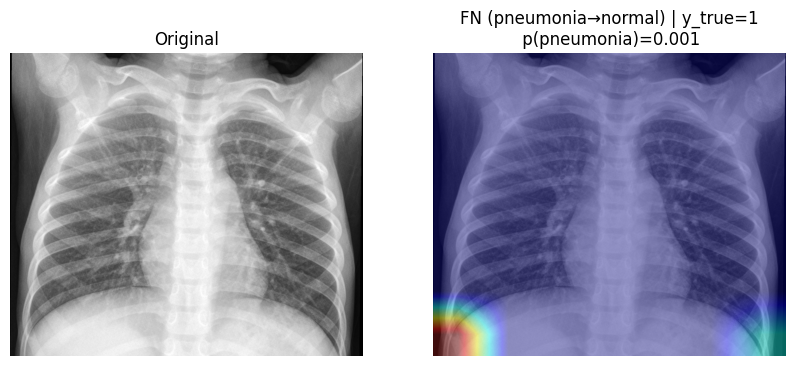

In [126]:
# 8.5 Executar Grad-CAM

# camada alvo: último bloco convolucional da EfficientNet
target_layer = model.features[-1]

gradcam = GradCAM(model, target_layer)

def run_one(idx, label_name):
    if idx is None:
        print(f"Sem exemplo disponível para {label_name}.")
        return
    path = df_va.loc[idx, "path"]
    x = tensor_from_path(path)

    # Ativa gradiente (necessário para Grad-CAM)
    model.zero_grad()
    cam, prob = gradcam(x)

    # título: tipo + classe verdadeira
    y_true = int(df_va.loc[idx, "label"])
    title = f"{label_name} | y_true={y_true}"
    show_gradcam(path, cam, prob, title=title)

run_one(tp_best, "TP (acerto pneumonia)")
run_one(fp_best, "FP (normal→pneumonia)")
run_one(fn_best, "FN (pneumonia→normal)")


## 8.6 Interpretação dos mapas Grad-CAM (TP / FP / FN)

A análise por Grad-CAM permite verificar se o modelo toma decisões baseadas em regiões
anatomicamente plausíveis (ex.: campos pulmonares) ou se utiliza "atalhos" (artefatos e bordas).

### Caso TP (acerto – pneumonia)
No exemplo verdadeiro positivo (TP), o mapa Grad-CAM se concentrou predominantemente nos pulmões.
Esse padrão é consistente com a tarefa, já que alterações compatíveis com pneumonia em radiografias
tendem a se manifestar como opacidades/infiltrados nos campos pulmonares.  
**Interpretação:** o modelo utiliza evidências visuais relevantes para a decisão, indicando boa plausibilidade clínica.

### Caso FP (erro – normal → pneumonia)
No falso positivo (FP), observou-se ativação forte na borda direita da imagem, em uma região escura
fora da área de interesse (fora do tórax).  
**Interpretação:** o modelo possivelmente foi influenciado por um artefato/estrutura de borda,
em vez de padrões internos do parênquima pulmonar. Esse comportamento é típico quando o modelo aprende
pistas não relacionadas à patologia (ex.: moldura do exame, contraste, ruído, cortes da imagem).

### Caso FN (erro mais crítico – pneumonia → normal)
No falso negativo (FN), o Grad-CAM focou em uma região periférica próxima a estruturas ósseas (área mais branca),
em vez de destacar de forma predominante os campos pulmonares.  
**Interpretação:** o modelo pode ter supervalorizado padrões de alto contraste (ossos/exposição) e subestimado sinais
pulmonares mais sutis, resultando na não detecção do caso positivo. Em um cenário clínico, esse tipo de erro é mais grave,
pois representa pneumonia não sinalizada pelo sistema.

### Implicações e possíveis melhorias
Os casos FP/FN sugerem que, apesar do alto desempenho global, o modelo pode ocasionalmente se apoiar em regiões
fora do pulmão. Estratégias que podem mitigar esse efeito incluem:
- pré-processamento para reduzir influência de bordas (ex.: crop central ou remoção de margens);
- augmentations mais robustas (variação de contraste/brightness) para reduzir dependência de exposição;
- (opcional) uso de segmentação/ROI dos pulmões para forçar o foco na área de interesse.


# 9. Geração do Arquivo de Submissão

Nesta seção geramos o arquivo `submission.csv` no formato exigido pela competição.

A predição final do conjunto de teste utiliza **ensemble dos 5 folds**, calculando a média das probabilidades:

- `id`: identificador do arquivo (exatamente como em `test.csv`)
- `target`: probabilidade prevista para pneumonia (classe positiva)

Ao final, salvamos `submission.csv` no diretório de trabalho para envio no Kaggle.


## 9.1 Construção do arquivo `submission.csv` (com sanity checks)

Antes de salvar, fazemos verificações rápidas para evitar erros comuns:

- O número de linhas deve ser igual ao número de amostras no teste.
- Os `id`s não devem ter duplicatas.
- Os valores de `target` devem estar no intervalo [0, 1].


In [128]:
# 9.1 Gerar submission.csv usando save_submission do src.inference
#
# A função save_submission já inclui sanity checks:
# - Verifica IDs duplicados
# - Verifica valores de target em [0, 1]
# - Exibe estatísticas da submissão

# Garante que temos predições para todo o teste
assert "test_pred_mean" in globals(), \
    "test_pred_mean não encontrado. Rode a Seção 6.5 (treinamento) ou Seção 6.6 (carregamento de modelos)."
assert "df_test" in globals(), "df_test não encontrado. Rode a Seção 4.3."
assert len(test_pred_mean) == len(df_test), "Quantidade de predições diferente do tamanho do df_test."

# 1) Salva no diretório do projeto
submission_path = os.path.join(PROJECT_DIR, "submission.csv")
submission = save_submission(df_test["id"], test_pred_mean, submission_path)

print(f"✅ Submissão salva em: {submission_path}")

# 2) Salva também no diretório atual (útil se for diferente do PROJECT_DIR)
local_path = os.path.abspath("submission.csv")
if local_path != submission_path:
    submission.to_csv(local_path, index=False)
    print(f"   Cópia local: {local_path}")

display(submission.head())

✅ /home/jose/Documentos/Ligia_CV/submission.csv salvo com sucesso!
Shape: (624, 2)
Target min/mean/max: 0.0000 / 0.7010 / 0.9999
✅ Submissão salva em: /home/jose/Documentos/Ligia_CV/submission.csv
   Cópia local: /home/jose/Documentos/Ligia_CV/notebooks/submission.csv


,id,target
0,img_0001.jpeg,0.180183
1,img_0002.jpeg,0.755337
2,img_0003.jpeg,0.998404
3,img_0004.jpeg,0.191286
4,img_0005.jpeg,0.006265
